In [199]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import os
from PIL import Image
import numpy as np
#from torch import mps


In [200]:
data_dir = '/Users/jli28/Desktop/Dataset'

if not os.path.exists(data_dir):
    print(f"Err: dataset dir not found at '{data_dir}'")
else:
    print(f"Dataset found at '{data_dir}'")

train_path = os.path.join(data_dir, 'train')

if not os.path.exists(train_path):
    print(f"Err: training subfolder not found at '{train_path}'")


Dataset found at '/Users/jli28/Desktop/Dataset'


In [201]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5332649..1.82].


Classes: ['Apple', 'Ball', 'Bird', 'Car', 'Dog', 'Plane']
Training dataset size: 57


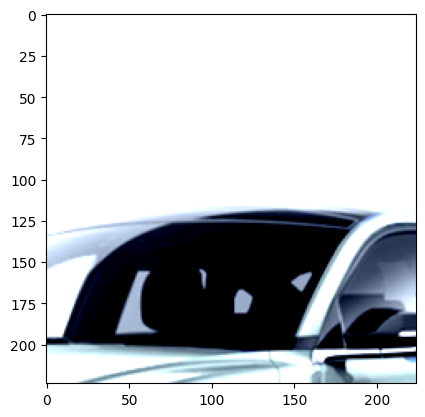

Label of img: Car


In [ ]:
# LOAD DATASET

data_dir = '/Users/jli28/Desktop/Dataset'
train_path = os.path.join(data_dir, 'train')

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

image_datasets = {'train': datasets.ImageFolder(train_path, data_transforms['train'])}

dataloaders = {'train': DataLoader(image_datasets['train'], batch_size=4, shuffle=True, num_workers=0)}

dataset_sizes = {'train': len(image_datasets['train'])}

class_names = image_datasets['train'].classes

print(f"Classes: {class_names}")
print(f"Training dataset size: {dataset_sizes['train']}")

inputs, labels = next(iter(dataloaders['train']))

# see imgs using matplotlib:
def imshow(img):
    img = img / 2 + 0.5 #unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(inputs[0].cpu())
print("Label of img:", class_names[labels[0]])

In [229]:
# BUILD NN (ResNet)

model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

# Num of input features for final fcl
num_ftrs = model.fc.in_features

num_classes = len(class_names)
model.fc = nn.Linear(num_ftrs, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu")
model = model.to(device)

print(model)

/Users/jli28/.pyenv/versions/3.11.1/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/jli28/.pyenv/versions/3.11.1/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [204]:
# LOSS FUNCTION & OPTIMIZER

criterion = nn.CrossEntropyLoss()

# optimize final fcl w/ Adam
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# SGD
#optimizer = optim.SGD(model.fc.parameters(), lr=0.01, momentum=0.9)

In [209]:
# TRAIN THE NN

def train_model(model, criterion, optimizer, dataloaders, dataset_sizes, num_epochs = 15):

    model.train()

    for epoch in range(num_epochs):

        print(f'Epoch {epoch + 1}')

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders['train']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels)

        epoch_loss = running_loss / dataset_sizes['train']
        epoch_acc = running_corrects / dataset_sizes['train']

        print(f'Loss: {epoch_loss:.2f} Accuracy: {epoch_acc:.2f}')
        print()

    return model

num_epochs = 15 # more epochs bc small dataset so why not :/
trained_model = train_model(model, criterion, optimizer, dataloaders, dataset_sizes, num_epochs)

print("TRAINING DONE! :D")

Epoch 1
Loss: 0.12 Accuracy: 0.96

Epoch 2
Loss: 0.40 Accuracy: 0.88

Epoch 3
Loss: 0.20 Accuracy: 0.91

Epoch 4
Loss: 0.19 Accuracy: 0.91

Epoch 5
Loss: 0.11 Accuracy: 0.96

Epoch 6
Loss: 0.16 Accuracy: 0.95

Epoch 7
Loss: 0.20 Accuracy: 0.91

Epoch 8
Loss: 0.14 Accuracy: 0.95

Epoch 9
Loss: 0.06 Accuracy: 0.96

Epoch 10
Loss: 0.20 Accuracy: 0.91

Epoch 11
Loss: 0.15 Accuracy: 0.95

Epoch 12
Loss: 0.21 Accuracy: 0.95

Epoch 13
Loss: 0.32 Accuracy: 0.86

Epoch 14
Loss: 0.20 Accuracy: 0.91

Epoch 15
Loss: 0.20 Accuracy: 0.93

TRAINING DONE! :D


In [206]:
# PREDICTIONS ON NEW IMGS

def predict_image(model, image_path, class_names, transforms, device):
    image = Image.open(image_path).convert('RGB')
    image_tensor = transforms(image).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad(): # no gradient calculation for inference
        output = model(image_tensor)
        _, predicted_index = torch.max(output, 1)
        prediction = class_names[predicted_index[0]]
        probability = torch.softmax(output, dim=1)[0][predicted_index[0]].item()

    return prediction, probability

In [207]:
# RUN PREDICTION

desktop_path = os.path.join(os.path.expanduser("~"), "Desktop")
test_img_path = os.path.join(desktop_path, "appleTest.jpg")

print(f"Opening img at: '{test_img_path}'")

try:
    prediction, probability = predict_image(trained_model, test_img_path, class_names, data_transforms['train'], device)
    print(f"Predicted class: {prediction}")
    print(f"Confidence: {probability:.2f}")

except FileNotFoundError:
    print(f"Err: img not found '{test_img_path}'")
except Exception as e:
    print(f"Err: {e}")

Opening img at: '/Users/jli28/Desktop/appleTest.jpg'
Predicted class: Apple
Confidence: 0.73
